In [38]:
import torch
from torch.utils.data import IterableDataset, DataLoader, Subset
from datetime import datetime, timedelta
import pandas as pd
import os
import random
import numpy as np
import torch.nn as nn
from pandas import DataFrame as df


#### Check device and assign device

In [39]:
# check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#### Assign Seed

In [40]:
seed = 42  # choose any seed you prefer
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

##### Build Custom Dataset Class

In [41]:
class PriceDataset(IterableDataset):
    def __init__(self, item, timespan, start_date_str, end_date_str):
        self.directory = f'csvfiles/{item}'
        self.item = item
        self.timespan = timespan
        start_date = datetime.strptime(start_date_str, '%Y-%m-%d').date()
        end_date = datetime.strptime(end_date_str, '%Y-%m-%d').date()
        self.dates = [single_date.strftime("%Y-%m-%d") for single_date in self.daterange(start_date, end_date)]
        self.columns = [0, 1, 2, 3, 4, 7]
        self.filenames = self.get_filenames()

    def daterange(self, start_date, end_date):
        for n in range(int((end_date - start_date).days) + 1):
            yield start_date + timedelta(n)

    def get_filenames(self):
        filenames = []
        for date in self.dates:
            filename = f"{self.directory}/{self.item}-{self.timespan}-{date}.csv"
            if os.path.exists(filename):
                filenames.append(filename)
        return filenames

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        df = pd.read_csv(filename, usecols=self.columns, header=None)
        return torch.tensor(df.values, dtype=torch.float32)

# Dataset is supposed to be [number of dates used][number of rows in each csv file][6, means the number of columns we are using in each csv file]


In [42]:
model1 = PriceDataset('BTCUSDT', '1m', '2021-03-01', '2023-04-30')

print(model1.__getitem__(1))

tensor([[1.6146e+12, 4.9596e+04, 4.9618e+04, 4.9515e+04, 4.9615e+04, 3.7691e+06],
        [1.6146e+12, 4.9615e+04, 4.9680e+04, 4.9603e+04, 4.9636e+04, 2.7946e+06],
        [1.6146e+12, 4.9636e+04, 4.9681e+04, 4.9616e+04, 4.9681e+04, 3.1195e+06],
        ...,
        [1.6147e+12, 4.8271e+04, 4.8302e+04, 4.8209e+04, 4.8282e+04, 1.0566e+06],
        [1.6147e+12, 4.8285e+04, 4.8320e+04, 4.8274e+04, 4.8306e+04, 6.4944e+05],
        [1.6147e+12, 4.8306e+04, 4.8476e+04, 4.8276e+04, 4.8441e+04, 3.3106e+06]])


##### Set Dataset and DataLoader
* Send Dataset and DataLoader to GPU for faster Calculation
* Make Batch for Dataloader
* Devide Training Set and Testing Set

In [43]:
def sliding_window_fn(batch):
    windows = []
    for tensor in batch:
        for i in range(tensor.shape[0] - 30 + 1):  # Create windows of 30 rows each
            windows.append(tensor[i:i+30])
    return torch.stack(windows)



# Create the dataset
dataset = PriceDataset('BTCUSDT', '1m', '2021-03-01', '2023-04-30')

# Shuffle the dataset indices
indices = list(range(len(dataset)))
random.shuffle(indices)

# Split the indices into training and test sets
split_idx = int(0.8 * len(indices))
train_indices, test_indices = indices[:split_idx], indices[split_idx:]

# Create data subsets using the indices
train_data = Subset(dataset, train_indices)
test_data = Subset(dataset, test_indices)

# Create the data loaders
train_loader = DataLoader(train_data, batch_size=1, collate_fn=sliding_window_fn, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=1, collate_fn=sliding_window_fn, shuffle=False, drop_last=True)

In [44]:
# To view first batch of the training data loader
for batch_idx, batch in enumerate(train_loader):
    print(f'Batch index: {batch_idx}, Batch tensor shape: {batch.shape}')
    break  # To prevent printing all the data

# To view first batch of the test data loader
for batch_idx, batch in enumerate(test_loader):
    print(f'Batch index: {batch_idx}, Batch tensor shape: {batch.shape}')
    break  # To prevent printing all the data





Batch index: 0, Batch tensor shape: torch.Size([1411, 30, 6])
Batch index: 0, Batch tensor shape: torch.Size([1331, 30, 6])


##### Build LSTM Model

In [45]:
class StackedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(StackedLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # The LSTM layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # The final Fully-Connected layer that gives us our predictions
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Layer to output probabilities
        self.probability = nn.Softmax(dim=-1)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)

        # Initialize cell state with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)

        # Get the outputs and the new hidden state from the LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Index hidden state of last time step
        out = self.fc(out[:, -5:, :])  # out.size() --> batch_size, output_dim

        # Get probabilities
        probs = self.probability(out)
        
        return out, probs



#### Train LSTM Model

In [46]:
# Model, Loss, and Optimizer
input_dim = 5   # Number of input features (excluding time)
hidden_dim = 150   # Number of hidden neurons in the LSTM layers
layer_dim = 5   # Number of stacked LSTM layers
output_dim = 5  # Number of output features (excluding time)

model = StackedLSTM(input_dim, hidden_dim, layer_dim, output_dim)
model = model.to(device)

criterion = nn.MSELoss()  # Use mean square error loss for regression problem
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Use Adam optimizer

# Set hyperparameters
epochs = 10

# loop over epochs
for epoch in range(epochs):

    # loop over the data loader
    for i, batch in enumerate(train_loader):
        features = batch[:, :, 1:].to(device)

        # forward pass: compute predicted outputs by passing inputs to the model
        output, probs = model(features)

        # targets for the last 5 timesteps (excluding time feature)
        targets = features[:, -5:, :]

        # calculate the loss
        loss = criterion(output, targets)

        # zero the gradients
        optimizer.zero_grad()

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # perform a single optimization step (parameter update)
        optimizer.step()

        # output training information
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


Epoch [1/10], Step [1/632], Loss: 4235305156608.0000
Epoch [1/10], Step [101/632], Loss: 2489881460736.0000
Epoch [1/10], Step [201/632], Loss: 722572279808.0000
Epoch [1/10], Step [301/632], Loss: 2391701716992.0000
Epoch [1/10], Step [401/632], Loss: 663110811648.0000
Epoch [1/10], Step [501/632], Loss: 30911429083136.0000
Epoch [1/10], Step [601/632], Loss: 1392776577024.0000
Epoch [2/10], Step [1/632], Loss: 4235185356800.0000
Epoch [2/10], Step [101/632], Loss: 2489788661760.0000
Epoch [2/10], Step [201/632], Loss: 722522013696.0000
Epoch [2/10], Step [301/632], Loss: 2391625695232.0000
Epoch [2/10], Step [401/632], Loss: 663071883264.0000
Epoch [2/10], Step [501/632], Loss: 30911127093248.0000
Epoch [2/10], Step [601/632], Loss: 1392713007104.0000
Epoch [3/10], Step [1/632], Loss: 4235073421312.0000
Epoch [3/10], Step [101/632], Loss: 2489697435648.0000
Epoch [3/10], Step [201/632], Loss: 722472599552.0000
Epoch [3/10], Step [301/632], Loss: 2391550459904.0000
Epoch [3/10], Step 

#### Model Evaluation

In [47]:
model.eval()  # set the model to evaluation mode

# Choose a sample from your test dataset
sample = test_data[0].unsqueeze(0).to(device)  # unsqueeze to add a batch dimension, exclude the time feature


# Get the model's predictions
with torch.no_grad():
    predictions, probabilities = model(sample)


RuntimeError: input.size(-1) must be equal to input_size. Expected 5, got 6

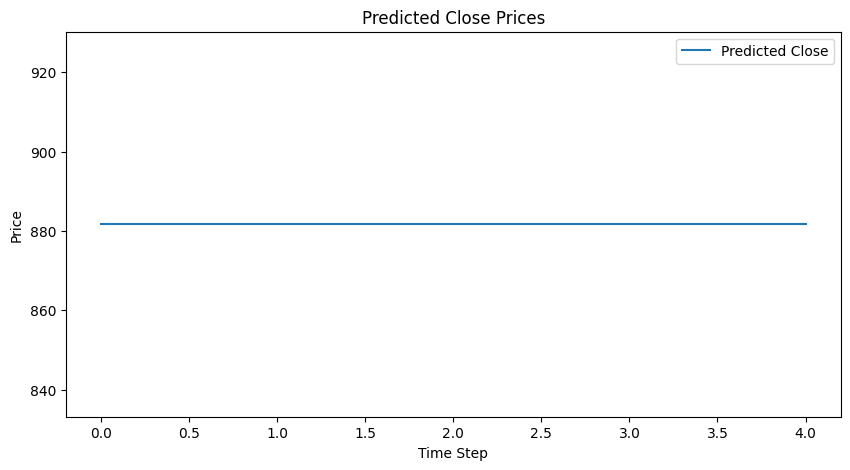

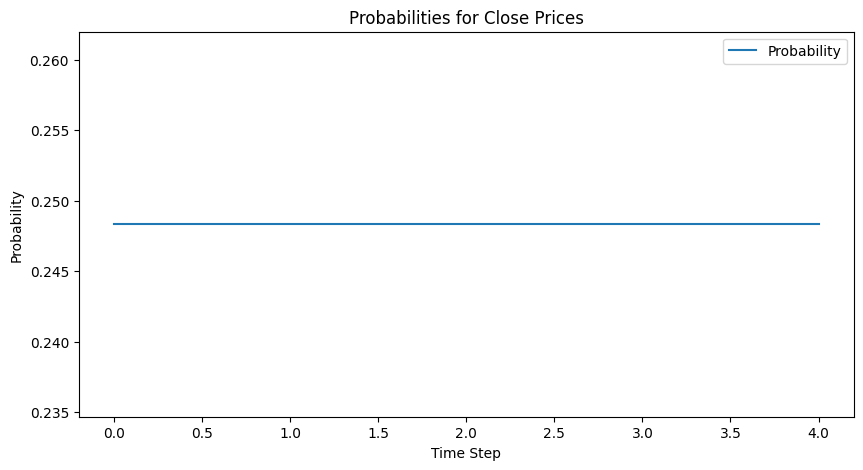

In [ ]:
import matplotlib.pyplot as plt

# Convert predictions and probabilities to numpy arrays
predictions = predictions.squeeze().cpu().numpy()
probabilities = probabilities.squeeze().cpu().numpy()

# Get the time steps
time_steps = list(range(len(predictions)))

# Plot the predictions
plt.figure(figsize=(10, 5))
plt.plot(time_steps, predictions[:, 3], label='Predicted Close')  # assuming close price is at index 3
plt.title('Predicted Close Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot the probabilities
plt.figure(figsize=(10, 5))
plt.plot(time_steps, probabilities[:, 3], label='Probability')  # assuming probability for close price is at index 3
plt.title('Probabilities for Close Prices')
plt.xlabel('Time Step')
plt.ylabel('Probability')
plt.legend()
plt.show()
